# Face similarity search w Vector Databases #
This notebook repeats the worked example of an app on Pineconce for finding your celebrity match. Link here: https://docs.pinecone.io/docs/facial-similarity-search

### Load dataset ###
First we get the image data for the vector DB. We'll use the huggingface dataset from The Movie Database (TMDB).

In [65]:
import pinecone
from datasets import load_dataset
pinecone.init(
    api_key="16825179-e09f-4405-b454-53629d6ade00", environment="us-west4-gcp-free"
)

# load the dataset
celeb_faces = load_dataset("ashraq/tmdb-people-image", split="train")
celeb_faces

Found cached dataset parquet (/Users/douglasbudge/.cache/huggingface/datasets/ashraq___parquet/default-f6987358ed4d9f01/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['adult', 'also_known_as', 'biography', 'birthday', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'name', 'place_of_birth', 'popularity', 'profile_path', 'image'],
    num_rows: 116403
})

In [ ]:
# examine data
celeb = celeb_faces[10]
celeb["image"].resize((200,300))

This dataset includes a lot of metadata like date of birth, place of birth etc.
Lots of this won't be relevant to a face matching application so we might as well drop it now.

In [58]:
metadata=celeb_faces.remove_columns(['adult', 'also_known_as', 'biography', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'image']).to_pandas()
metadata=metadata.fillna("None")

## Embedding model method ##
When using a vector database, an effective vector embedding model is crucial. Vector embedding is the method of vectorising data into a higher dimensional space and this step impacts the quality of results. Using accurate embeddings indicates how similar records are and allows Pinecone to store similar records together. Returning similar records from that point is just a case of calculating nearest neighboring records. We'll fetch records later in the notebook but for now let's look at the vector embedding we'll use.

The pipeline needs two different models; one to detect faces and one to encode embeddings. We'll use package options for both and combine them into one pipeline.
Pytorch has an implementation of MTCNN which we can use to detect faces. This is a popular option since it performs well with different poses and appearances plus it expects images in PIL format which ours already are. 

In [59]:
from facenet_pytorch import MTCNN
mtcnn= MTCNN()
img= celeb["image"].copy()
boxes, prob = mtcnn.detect(img)
boxes,prob

(array([[91.48239135742188, 112.33537292480469, 316.8033447265625,
         409.37725830078125]], dtype=object),
 array([0.9999923706054688], dtype=object))

The detect method of MTCNN gives us coordinate boxes and a confidence level of detection (>99% acccurate in this case). We'll sense check the coordinates by drawing them on an image.

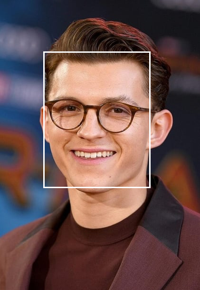

In [60]:
from PIL import Image, ImageDraw
square= boxes.reshape((2,2))
x,y=tuple(square[0]),tuple(square[1])

# draw a rectangle on the image using coordinates returned by the MTCNN model
draw = ImageDraw.Draw(img)
draw.rectangle(x+y, width=3)
# resize the image to display a smaller size
img.resize((200, 290))

To extract the face we can crop the area outside of the box. `facenet_pytorch` has an option to do this and the output is tensors which we can pass directly into the embedding model.

In [66]:
# pass the image or batch of images directly through mtcnn model
face = mtcnn(img)
face.shape

torch.Size([3, 160, 160])

Embedding the faces next; we'll use another pytorch model VGGFace2. This has been pretrained on on the VGGFace2 dataset which has millions of images of 9000 people. 

In [67]:
from facenet_pytorch import InceptionResnetV1
import torch

# initialize VGGFace2 model
resnet = InceptionResnetV1(pretrained="vggface2").eval()
# generate embedding for the face extracted using mtcnn above
embedding = resnet(torch.stack([face]))
embedding.shape


torch.Size([1, 512])

Now we have the models, let's create a pipeline to generate embeddings in batches

In [68]:
import numpy as np

class FacenetEmbedder:
    def __init__(self):
        # set device to use GPU if available
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        # initialize MTCNN model
        self.mtcnn = MTCNN(device=self.device)
        # initialize VGGFace2 model
        self.resnet = InceptionResnetV1(pretrained='vggface2', device=self.device).eval()

    def detect_face(self, batch):
        # get coordinates of the face
        faces = self.mtcnn.detect(batch)
        return faces

    def encode(self, batch):
        # pass the batch of images directly through mtcnn model
        face_batch = self.mtcnn(batch)
        # remove any images that does not contain a face
        face_batch = [i for i in face_batch if i is not None]
        # concatenate face batch to form a single tensor
        aligned = torch.stack(face_batch)
        # if using gpu move the input batch to gpu
        if self.device.type == "cuda": 
            aligned = aligned.to(self.device)
        # generate embedding
        embeddings = self.resnet(aligned).detach().cpu()
        return embeddings.tolist()
    



In [69]:
# intialize the embedder
facenet= FacenetEmbedder()

# test the pipeline with a small batch
batch= celeb_faces[10:20]['image']
len(facenet.encode(batch))


10

Now all we'll need to do is call the encode method on a batch of PIL images, so long as they're all the same shape.

## Initialize Pinecone Index ##
It's time to initialize pinecone so we can upsert images as vector representations. If everything works, we can then search the DB with a a query vector which is just an embedding of a new image. I actually initialized Pinecone at the start of this notebook, the relevant details are all in the Pinecone console under API KEYS.

Creating the vector index, you must choose a name, the vector space metric (cosine) and vector space dimension (512).

In [49]:
# Create vector index
index_name= 'tmdb-people'

# check if index name exists
if index_name not in pinecone.list_indexes():
    #create index if it doesn't exist
    pinecone.create_index(
        index_name,
        dimension= 512,
        metric='cosine'
    )

# connect to created index
index= pinecone.GRPCIndex(index_name)



In [50]:
def reshape(batch):
    batch = [image.convert("RGB").resize((421, 632)) for image in batch]
    return batch

In [55]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(celeb_faces), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(celeb_faces))
    # extract batch
    batch = celeb_faces[i:i_end]["image"]
    # reshape the images to ensure they all have same shape
    batch = reshape(batch)
    # generate embeddings for batch
    try:
        emb = facenet.encode(batch)
    except:
        pass
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add metadata
    meta = metadata[i:i_end].to_dict(orient="records")
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# # check that we have all vectors in index
index.describe_index_stats()

  0%|          | 0/1819 [00:00<?, ?it/s]